# Handwritten text recognition with Connectionist Temporal Classification (CTC)

Suggested reading: ["Sequence Modeling With CTC" by Awni Hannun](https://distill.pub/2017/ctc/).

Text, audio, video, etc., are naturally modeled as sequences, and many problems involving them can be formulated as sequence-to-sequence processing.

Neural networks like RNNs and CNNs, can easily address some of the cases:
* many-to-one problems, where a single output is assigned to the whole input sequence;
* one-to-one problems, where there is one output element for each input element.

General many-to-many problems demand complex architectures involving multiple networks (e.g., encoder-decoder models).

Contextual Temporal Classification (CTC) is an efficient and elegant technique proposed in 2006 to deal with some many-to-many problems using a single RNN or CNN (read the [original paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf)).

In particular, CTC addresses problems entailing segmentation and classification:
* the input sequence is segmented into groups of consecutive elements;
* a class label is assigned to each group;
* the output is the sequence of class labels.

Handwritten text recognition and speech recognition are examples of this kind of problems, where the characters are the class labels.

![](https://distill.pub/2017/ctc/assets/handwriting_recognition.svg) ![](https://distill.pub/2017/ctc/assets/speech_recognition.svg)

## Handwritten text recognition

In this exercise we will use CTC to implement a system for handwritten text recognition.

We will used a processed version of the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), including 5000 lines of handwritten text (4500 for training and 500 for test). For each line, a transcript with the correct text is available. Note that the lines do not form complete sentences, and may include English letters, digits, the punctuation symbols `,.'-!?:;"`, and the white space character.

## Setup and Data


The dataset is distributed as an archive with the following structure:

```
handwritten/
├── train/
│   ├── images/
│   │   ├── 0001.png
│   │   ├── 0002.png
│   │   ├── 0003.png
│   │   ├── ...
│   │   └── 4500.png
│   └── sentences.txt
└── test/
    ├── images/
    │   ├── 4501.png
    │   ├── 4502.png
    │   ├── 4503.png
    │   ├── ...
    │   └── 5000.png
    └── sentences.txt
```
The two `sentences.txt` files report the text displayed in the images, one per line, in the order following the enumeration of the files.  Images have been already resized to $400 \times 32$ pixels.

Let's start by importing all the libraries we will need and extracting the data from the archive. The archive also includes the `edit_distance.py` module, which we will also need later.

In [1]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

import zipfile
import os



In [4]:
from google.colab import drive
import zipfile



# Define the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/Colab Notebooks (1)/handwritten.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/handwritten")

print("Extraction complete.")


Extraction complete.


## Dataset and data loaders

Now we need to setup the datasets and the data loaders.  We can reuse the `ImageFolder` class provided by the `torchvision` module.  However, we need to replace the useless class labels with the information read from the `sentences.txt` files.

It would be better if all sentences were the same length so that we could use a single tensor to represent a batch of text. We assume that no sentence is longer than 30 characters, and we will use a special `PAD` character to fill sentences that are shorter than that.

We also reserve a special `BLANK` character that CTC needs.

Note that `ImageFolder` loads RGB color images, but color is not a very useful feature for this particular problem. We will convert the images to grayscale by using the `torchvision.transforms.Grayscale` transform.

In [5]:
import os

# List the contents of the extracted directory
extracted_path = "/content/handwritten"
for root, dirs, files in os.walk(extracted_path):
    print(root, dirs, files)


/content/handwritten ['handwritten'] ['edit_distance.py']
/content/handwritten/handwritten ['train', 'test'] []
/content/handwritten/handwritten/train ['images'] ['sentences.txt']
/content/handwritten/handwritten/train/images [] ['3413.png', '3829.png', '3828.png', '1789.png', '0955.png', '3002.png', '4480.png', '3376.png', '4415.png', '1350.png', '2308.png', '0707.png', '4097.png', '4297.png', '4090.png', '3152.png', '4351.png', '0498.png', '1578.png', '2418.png', '0913.png', '2720.png', '1182.png', '1289.png', '3731.png', '2813.png', '1886.png', '0202.png', '1475.png', '4452.png', '3846.png', '2602.png', '1379.png', '1446.png', '0424.png', '2293.png', '0731.png', '2817.png', '3873.png', '0494.png', '3130.png', '2404.png', '4314.png', '1438.png', '0924.png', '1012.png', '2651.png', '2508.png', '2410.png', '1622.png', '3783.png', '2173.png', '3302.png', '3462.png', '0201.png', '2058.png', '2287.png', '4158.png', '2896.png', '0253.png', '0533.png', '2656.png', '0252.png', '4396.png', '3

torch.Size([32, 1, 32, 400]) torch.float32
torch.Size([32, 30]) torch.uint8
torch.Size([32]) torch.int64


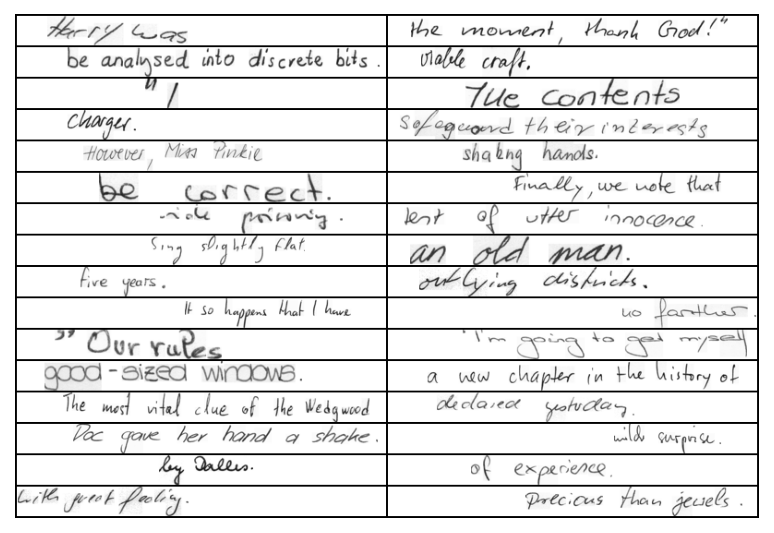

Harry was===================== 9
the moment , thank God ! "==== 26
be analysed into discrete bits 30
viable craft .================ 14
" I=========================== 3
The contents================== 12
charges .===================== 9
safeguard their interests===== 25
However , Miss Pinkie========= 21
shaking hands .=============== 15
be correct .================== 12
Finally , we note that======== 22
cide poisoning .============== 16
tent of utter innocence .===== 25
Sing slightly flat .========== 20
an old man .================== 12
five years .================== 12
outlying districts .========== 20
It so happens that I have===== 25
no farther .================== 12
" Our rules=================== 11
" I 'm going to get myself==== 26
good-sized windows .========== 20
a new chapter in the history o 30
The most vital clue of the Wed 30
declared yesterday .========== 20
Doc gave her hand a shake .=== 27
mild surprise .=============== 15
by Dallas .=================== 11
of experience .==

In [6]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

CHARS = "~=" + " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,.'-!?:;\""
BLANK = 0 # is ~
PAD = 1 # is =
CHARS_DICT = {c: i for i, c in enumerate(CHARS)}
TEXTLEN = 30 # default length of lines, but it will cut some of the text

class SingleFolderImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.images = sorted([f for f in os.listdir(os.path.join(root, "images")) if os.path.isfile(os.path.join(root, "images", f))])
        path = os.path.join(root, "sentences.txt")
        text = []
        lengths = [] # cause padding should not be part of evaluation ..> consider only this original length
        with open(path) as f:
            for line in f:
                codes = [CHARS_DICT[c] for c in line.strip()[:TEXTLEN]] # [:TEXTLEN] to cut line in case longer
                lengths.append(len(codes))
                codes += [PAD] * (TEXTLEN - len(codes)) # if it's too short, i could pad at the start of the sentences
                text.append(codes)
        self.sentences = torch.tensor(text, dtype=torch.uint8)
        self.lengths = torch.tensor(lengths)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, "images", self.images[index])
        image = Image.open(image_path).convert("L")  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        return image, self.sentences[index], self.lengths[index]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5) # assume mean=0.5, std=0.5 --> (x-mean)/std, normalize to speed up training
])

train_set = SingleFolderImageDataset("handwritten/handwritten/train", transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
test_set = SingleFolderImageDataset("handwritten/handwritten/test", transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

def show_batch(batch):
    plt.rcParams['figure.dpi'] = 150
    g = torchvision.utils.make_grid(batch, normalize=True, value_range=(-1, 1), nrow=2) # value_range=(-1,1) of pixels
    plt.imshow(g.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

def decode_text(codes):
    chars = [CHARS[c] for c in codes]
    return "".join(chars)

images, sentences, lengths = next(iter(train_loader))
print(images.shape, images.dtype) # [32, 1, 32, 400], 32=batch, 1=channel, 32=vertical pixel, 400=horizontal pixel ?
print(sentences.shape, sentences.dtype)
print(lengths.shape, lengths.dtype)
show_batch(images)
for sentence, length in zip(sentences, lengths):
    print(decode_text(sentence), length.item())


## Model

CTC requires a model that assigns a class label (or a blank) to each element in an input sequence.

We will build a hybrid model: first, a convolutional network will transform the original $400 \times 32$ image into a sequence of $100$ feature vectors.

Then, a bidirectional LSTM will assign the probability estimates to all elements in the sequence.

The convolutional part is a sequence if *residual blocks* computing
$$ y = \text{relu}(F_2(\text{relu}(F_1(x))) + x) $$
+x to create residual
where $F_{\{1,2\}}$ are the composition of a convolution and a batch normalization.  The skip connection $\dots + x$ is replaced by a $1 \times 1$ convolution when the shape of the two addends do not match.  The blocks include an optional stride, and a final dropout.

In [7]:
### RELU BEACUSE WE NEED NON LINEARITIES, IN FACT OTHERWISE IT WOULD BE ONLY SUMS OF LINEAR OPERATORS BUT I WANT NON LINEARITIES, OTHERWISE I CAN JUST PRECOMPUTE ALL THE LINEAR OPERATOR???
# NOTE: BATHC_NORM AFTER TRAINING IS A LINEAR OPERATOR

In [8]:
class Residual(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride, pdrop=0.2):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        if in_channels != out_channels or stride != 1: # if one of these 2 then shapes are different, so apply self.skip
          self.skip = torch.nn.Conv2d(in_channels, out_channels, 1, stride, 0)
        else:
          self.skip = torch.nn.Identity()
        self.dropout = torch.nn.Dropout2d(pdrop) # it will drop not pixels, but channels, cause otherwise the model would be able to recomopute the dropped pixel --> strong correlation among pixel
    def forward(self, x):
        y = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        y = torch.nn.functional.relu(self.bn2(self.conv2(y)) +self.skip(x)) # if i apply self.skip(x) with conv i will lose some information of the original x but i need shapes to match
        # with droput shape(self.conv2(y)) might != self.skip(x) in that case torch might adds self.skip(x) only to the available self.conv2(y)
        y = self.dropout(y)
        return y

The full model includes a feature extractor of 9 residual blocks, the bidirectional LSTM, and a final linear layer.

In [9]:
class TextRecognizer(torch.nn.Module):
    def __init__(self, labels):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(
            Residual(1,32,1),
            Residual(32,32,2),
            Residual(32,32,2),
            Residual(32,64,1),
            Residual(64,64,1),
            Residual(64,128,(2,1)), # apply two different strides horizontally and vertically
            Residual(128,128,1),
            Residual(128,128,(2,1)),
            Residual(128,128,(2,1)) # from image to sequence
        )
        self.recurrent = torch.nn.LSTM(128,128,1,bidirectional=True) # first 128 is the size of input, second 128 are the feature of lstm used to predict next state
        #  1=layer of LSTM, bidirectional the net will look at left and right --> 128*2 output shape
        self.output = torch.nn.Linear(256, labels)
    def forward(self, x):
        x = self.feature_extractor(x) # from [1, 1, 32, 400] to [1, 128, 1, 100] #128 are the features, 1 is vertical, 100 is horizontal
        x = x.squeeze(2) # from [1, 128, 1, 100] to [1, 128, 100]
        x = x.permute(2,0,1) # from [1, 128, 100] to [100, 1 , 128]
        x, _ = self.recurrent(x) # from [100, 1 , 128] to [100, 1, 256]
        x = self.output(x) # from [100, 1, 256] to [100, 1, 74]
        return x


In [10]:
recognizer = TextRecognizer(len(CHARS))
x = torch.zeros(1, 1, 32, 400) # first 1 would be the batch, second 1 is the channel
y = recognizer(x)
print(x.shape, "=>", y.shape)
ps = sum(p.numel() for p in recognizer.parameters())
print(ps, "parameters")

torch.Size([1, 1, 32, 400]) => torch.Size([100, 1, 74])
1614570 parameters


## Training

In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
LR = 1e-3

recognizer.to(DEVICE)
optimizer = torch.optim.Adam(recognizer.parameters(), lr=LR)

Device: cuda


### Utility functions
These are used during training and evaluation.

In [12]:
def ctc_decode_sequence(seq):
    """Removes blanks and repetitions from the sequence."""
    ret = []
    prev = BLANK
    for x in seq:
        if prev != BLANK and prev != x:
            ret.append(prev)
        prev = x
    return ret

def ctc_decode(codes):
    """Decode a batch of sequences."""
    ret = []
    for cs in codes.T:
        ret.append(ctc_decode_sequence(cs))
    return ret

def accuracy(logits, targets):
    """Computes the accuracy of the predictions, ignoring padding."""
    ok = 0
    tot = 0
    predictions = ctc_decode(logits.argmax(2))
    for ps, ts in zip(predictions, targets):
        ok += sum(p == t for p, t in zip(ps, ts) if t != PAD)
        tot += sum(t != PAD for t in ts)
    return ok / tot

def save_model(filename):
    data = {
        "recognizer": recognizer.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    torch.save(data, zip_file_path + filename)

def load_model(filename):
    data = torch.load(zip_file_path + filename)
    recognizer.load_state_dict(data["recognizer"])
    optimizer.load_state_dict(data["optimizer"])

### Training loop

The main component here is the CTC loss. Pytorch includes the `CTCLoss` module implenting it ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html#torch.nn.CTCLoss)). This module takes as arguments:
* the logarithm of the probability estimates, that can be computed with the `log_softmax` function (combining `log` and `softmax` would make the computation be less accurate).
* The batch of target class labels.
* The lengths of the sequences of probability estimates (100, in our case).
* The lengths of the target sequences, not counting padding.

The problem is challenging, and many epochs are required to get decent results.

In [13]:

EPOCHS = 5  # Try with 50, or more

recognizer.train()

ctc_loss = torch.nn.CTCLoss()
steps = 0
for epoch in range(EPOCHS):
    for x, y, lengths in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        # we did not move the lengths to device, as required by CTCLoss
        optimizer.zero_grad()
        scores = recognizer(x)
        ilengths = torch.full((scores.shape[1], ), scores.shape[0])
        loss = ctc_loss(torch.nn.functional.log_softmax(scores, 2), y, ilengths, lengths) # log because the loss can then sum up the probabilities instead of multiplying them
        # 2 is the dimension along to which log_softmax is computed, scores.shape = [batch, don't know, 1, 74] ??
        loss.backward()
        optimizer.step()
        steps += 1
        if steps % 100 == 0:
            acc = accuracy(scores, y) # accuracy per batch, not the global accuracy, i might get high accuracy cause the batch is easy
            print(f"{steps}[{epoch}] loss: {loss.item():.4f}, acc: {acc.item():.4f}%")
    save_model("model.pt")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100[0] loss: 3.6611, acc: 0.0000%
200[1] loss: 3.3200, acc: 0.0000%
300[2] loss: 3.2670, acc: 0.0000%
400[2] loss: 3.0820, acc: 0.0018%
500[3] loss: 2.8364, acc: 0.0130%
600[4] loss: 2.7098, acc: 0.0215%
700[4] loss: 2.6750, acc: 0.0325%


## Evaluation

To evaluate the model, we need a perfomance measure. The accuracy of the prediction of single characters is not a good measure, because:
* predictions are spread over multiple elements in the sequence;
* output and target sequences may have different lengths (in case of errors).

A simple alternative is sequence level accuracy, that is, the fraction of sequences correctly identified.  However, this would count equally bad sequences with one error and with many errors.

A more sophisticated error measure is the edit distance, also called [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)), which counts the minimal number of editing operations (insertions, deletions, substitutions) to transform the prediction in the target sequence.

The edit distance can be effectively computed with a $O(n^2)$ dynamic programming algorithm, and is implemented in the `edit_distance.py` module.

In [14]:
# if for accuracy:
#   the cat is on the roof  is a correct prediction
#   then
#   he cat is on the roof   is completely wrong

In [15]:
def edit_distance(pred, target):
    """ Compute the Levenshtein distance between two sequences. """
    m, n = len(pred), len(target)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if pred[i - 1] == target[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1]) + 1

    return dp[m][n]

In [16]:
load_model("model.pt")
recognizer.eval()
tot_acc=0
tot_dist=0
n=0
for x,y,lengths in test_loader:
  x = x.to(DEVICE)
  y = y.to(DEVICE)
  with torch.no_grad():
    scores = recognizer(x)
  predictions = scores.argmax(2)
  decoded = ctc_decode(predictions)
  acc=accuracy(scores, y)
  tot_acc += acc
  for ps, ds,ts,length in zip(predictions.T, decoded, y, lengths): # first dimension of predictions is the temporal dimension
    dist = edit_distance(ds, ts[:length])
    tot_dist += dist
    n+= 1
    if n < 50:
      txt1 = decode_text(ts)
      txt2 =decode_text(ps)
      txt3 = decode_text(ds)
      print(f"{n:3d} |{txt1}|{txt2}|{txt3}| {dist}")
print(f"acc {100*tot_acc/n:.1f}%")
print(f"avg distance {tot_dist/n:.3f}%")

  1 |echo-sounders .===============|~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~|  | 14
  2 |Farnese , with a snigger .====|~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  ~~~~~~~~~~~~td  ~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~| td  | 22
  3 |" The jackals bay=============|~~~~~~~~~~~~~~~   ~~~~~~~~~~~~~   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~|   | 14
  4 |written in Greek .============|~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~  ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~|   | 15
  5 |It seems obvious that , though|~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~  ~~~~~~~~~~~~~~  ~~~~~~td  ~~~~~~~~~~~~~~~~~~~~~~~|   td | 25
  6 |psychologist I am constantly==|~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~t  ~~~~~~~~~~~~~   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~|t  | 25
  7 |The definition of an==========|~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  ~~~~~~~~t  ~

In [17]:
# the dataset is not large so there might be some overfitting

## Questions

In the report, answer to the following questions:
* Find text lines with few and many errors. Which characteristics most influence the accuracy of predictions?
* Is the model overfitting the data?
* Does bidirectional LSTM perform better than simple LSTM?
* Is dropout useful?


## Extensions

The models presented here are by no means optimal. Try to identify the best combination of parameters, also by adjusting the number of features, blocks etc.

Other possible investigations:
* Try a fully convutional approach, with a final convolution with a large (along the sequence direction) kernel, instead of the LSTM.
* Try to incorporate some knowledge about the language to fix some of the errors (perhaps even a language model). Incorporate a beam search algorithm.

For the last two points you can take inspiration from ["Sequence Modeling With CTC" by Awni Hannun](https://distill.pub/2017/ctc/).

Finding Text Lines with Few and Many Errors:



In [18]:
results = []
for x, y, lengths in test_loader:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        scores = recognizer(x)
    predictions = scores.argmax(2)
    decoded = ctc_decode(predictions)
    for ps, ds, ts, length in zip(predictions.T, decoded, y, lengths):
        dist = edit_distance(ds, ts[:length])
        results.append((dist, decode_text(ts), decode_text(ps), decode_text(ds)))

# Sort results by edit distance
results.sort(key=lambda x: x[0])

# Display top 5 lines with fewest errors
print("Top 5 lines with fewest errors:")
for dist, ts, ps, ds in results[:5]:
    print(f"Dist: {dist}, Target: {ts}, Predicted: {ps}, Decoded: {ds}")

# Display top 5 lines with most errors
print("\nTop 5 lines with most errors:")
for dist, ts, ps, ds in results[-5:]:
    print(f"Dist: {dist}, Target: {ts}, Predicted: {ps}, Decoded: {ds}")


Top 5 lines with fewest errors:
Dist: 1, Target: A=============================, Predicted: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~, Decoded: 
Dist: 2, Target: It============================, Predicted: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~, Decoded: 
Dist: 2, Target: In============================, Predicted: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~, Decoded: 
Dist: 2, Target: He============================, Predicted: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~, Decoded: 
Dist: 2, Target: He============================, Predicted: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~, Decoded: 

Top 5 lines with most errors:
Dist: 27, Target: Courier knows what 's going on, Predicted: ~~~~~~~~~~~~~~~~

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Residual block definition
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, pdrop=0.2, use_dropout=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.use_dropout = use_dropout
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Conv2d(in_channels, out_channels, 1, stride, 0)
        else:
            self.skip = nn.Identity()
        self.dropout = nn.Dropout2d(pdrop) if use_dropout else nn.Identity()

    def forward(self, x):
        y = torch.relu(self.bn1(self.conv1(x)))
        y = torch.relu(self.bn2(self.conv2(y)) + self.skip(x))
        y = self.dropout(y)
        return y

# TextRecognizer model definition
class TextRecognizer(nn.Module):
    def __init__(self, labels, bidirectional=True, use_dropout=True):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            Residual(1, 32, 1, use_dropout=use_dropout),
            Residual(32, 32, 2, use_dropout=use_dropout),
            Residual(32, 32, 2, use_dropout=use_dropout),
            Residual(32, 64, 1, use_dropout=use_dropout),
            Residual(64, 64, 1, use_dropout=use_dropout),
            Residual(64, 128, (2, 1), use_dropout=use_dropout),
            Residual(128, 128, 1, use_dropout=use_dropout),
            Residual(128, 128, (2, 1), use_dropout=use_dropout),
            Residual(128, 128, (2, 1), use_dropout=use_dropout)
        )
        self.recurrent = nn.LSTM(128, 128, 1, bidirectional=bidirectional)
        self.classifier = nn.Linear(128 * (2 if bidirectional else 1), len(labels))
        self.labels = labels

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.permute(0, 3, 1, 2)  # (batch_size, width, height, channels)
        features = features.view(features.size(0), features.size(1), -1)  # (batch_size, width, height * channels)
        features = features.permute(1, 0, 2)  # (width, batch_size, height * channels)
        recurrent_out, _ = self.recurrent(features)
        output = self.classifier(recurrent_out)
        return output





In [20]:
# Function to train and evaluate a model
def train_and_evaluate(model, train_loader, test_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for images, targets, lengths in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images).log_softmax(2)
            input_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long)
            loss = criterion(outputs, targets, input_lengths, lengths)
            loss.backward()
            optimizer.step()

    results = evaluate(model, test_loader, device)
    return results

# Function to evaluate a model
def evaluate(model, loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for x, y, lengths in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x).log_softmax(2)
            predictions = scores.argmax(2)
            decoded = ctc_decode(predictions)
            for ps, ds, ts, length in zip(predictions.T, decoded, y, lengths):
                dist = edit_distance(ds, ts[:length])
                results.append(dist)
    return results

In [21]:
# Assuming train_loader and test_loader are already defined
labels = "~=" + " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,.'-!?:;\""

# Bidirectional LSTM
bidirectional_model = TextRecognizer(labels, bidirectional=True, use_dropout=True)
bidirectional_results = train_and_evaluate(bidirectional_model, train_loader, test_loader)

# Simple LSTM
simple_lstm_model = TextRecognizer(labels, bidirectional=False, use_dropout=True)
simple_lstm_results = train_and_evaluate(simple_lstm_model, train_loader, test_loader)

# Bidirectional LSTM without dropout
bidirectional_no_dropout_model = TextRecognizer(labels, bidirectional=True, use_dropout=False)
bidirectional_no_dropout_results = train_and_evaluate(bidirectional_no_dropout_model, train_loader, test_loader)

# Display results
print("Bidirectional LSTM Results:", bidirectional_results)
print("Simple LSTM Results:", simple_lstm_results)
print("Bidirectional LSTM without Dropout Results:", bidirectional_no_dropout_results)

Bidirectional LSTM Results: [12, 12, 12, 9, 19, 21, 9, 6, 17, 10, 13, 14, 18, 4, 12, 25, 12, 12, 7, 12, 14, 13, 4, 1, 2, 14, 10, 8, 1, 13, 15, 12, 10, 4, 18, 12, 16, 19, 16, 11, 15, 6, 4, 13, 8, 8, 5, 16, 14, 10, 17, 11, 22, 20, 10, 24, 9, 11, 6, 2, 8, 16, 11, 16, 21, 6, 18, 12, 9, 11, 8, 12, 10, 10, 16, 15, 18, 8, 15, 7, 4, 14, 14, 3, 6, 21, 6, 10, 6, 15, 7, 10, 20, 12, 11, 8, 8, 18, 19, 18, 5, 16, 21, 24, 0, 7, 7, 7, 7, 4, 14, 10, 6, 9, 12, 14, 12, 9, 18, 15, 21, 16, 10, 19, 15, 15, 8, 14, 22, 20, 12, 19, 13, 2, 15, 10, 8, 14, 11, 20, 7, 7, 6, 8, 14, 14, 18, 13, 12, 18, 15, 7, 5, 19, 10, 16, 11, 4, 11, 13, 8, 12, 5, 1, 21, 8, 0, 23, 20, 6, 6, 12, 3, 20, 2, 17, 4, 16, 4, 11, 10, 16, 4, 11, 11, 3, 17, 6, 14, 11, 19, 6, 3, 20, 12, 17, 6, 7, 14, 11, 16, 7, 14, 10, 13, 6, 11, 11, 3, 8, 9, 5, 9, 6, 9, 11, 5, 1, 18, 3, 2, 7, 22, 15, 5, 8, 18, 19, 7, 13, 14, 21, 14, 21, 8, 2, 14, 22, 13, 12, 4, 5, 3, 22, 20, 12, 10, 7, 2, 15, 11, 22, 12, 8, 15, 5, 19, 6, 9, 17, 9, 3, 9, 13, 12, 0, 13, 14, 16

In [22]:
import os

# Load sentences from the sentences.txt file
def load_sentences(sentences_file):
    with open(sentences_file, 'r') as f:
        sentences = [line.strip() for line in f]
    return sentences


# Assuming the path to the sentences file
sentences_file = "/content/handwritten/handwritten/train/sentences.txt"
sentences = load_sentences(sentences_file)

# Assuming the necessary imports and data loading steps are done earlier in the notebook
# Assuming evaluate function and train_and_evaluate function are already defined

# Train and evaluate models to get the results
labels = "~=" + " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,.\'-!?:;\""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to find text lines with few and many errors
def analyze_errors(results, sentences):
    errors = sorted(results)
    fewest_errors = errors[:5]
    most_errors = errors[-5:]

    print("Lines with fewest errors:")
    for i, error in enumerate(fewest_errors):
        print(f"Error {i+1}: {error}, Sentence: {sentences[i]}")

    print("\nLines with most errors:")
    for i, error in enumerate(most_errors):
        print(f"Error {i+1}: {error}, Sentence: {sentences[len(sentences) - 5 + i]}")

# Function to analyze characteristics influencing accuracy
def analyze_characteristics(results, sentences):
    lengths = [len(sentence) for sentence in sentences]
    errors = results
    plt.scatter(lengths, errors)
    plt.xlabel('Text Length')
    plt.ylabel('Errors (Edit Distance)')
    plt.title('Text Length vs Errors')
    plt.show()

    char_freqs = Counter(''.join(sentences))
    errors_by_char = {char: 0 for char in char_freqs.keys()}
    for sentence, error in zip(sentences, errors):
        for char in sentence:
            errors_by_char[char] += error

    sorted_errors_by_char = sorted(errors_by_char.items(), key=lambda x: x[1], reverse=True)
    print("Character influence on errors (sorted by most errors):")
    for char, error in sorted_errors_by_char:
        print(f"Character: {char}, Total Errors: {error}")

# Function to check for overfitting
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

# Evaluate


In [23]:
# Evaluate model and get results
results = evaluate(bidirectional_model, test_loader, device)  # Assuming using bidirectional model for analysis

# Check lengths of results and sentences
print(f"Length of results: {len(results)}, Length of sentences: {len(sentences)}")


Length of results: 500, Length of sentences: 4500


In [24]:
# Function to find text lines with few and many errors
def analyze_errors(results, sentences):
    errors = sorted(results)
    fewest_errors = errors[:5]
    most_errors = errors[-5:]

    print("Lines with fewest errors:")
    for i, error in enumerate(fewest_errors):
        print(f"Error {i+1}: {error}, Sentence: {sentences[i]}")

    print("\nLines with most errors:")
    for i, error in enumerate(most_errors):
        print(f"Error {i+1}: {error}, Sentence: {sentences[len(sentences) - 5 + i]}")

# Function to analyze characteristics influencing accuracy
def analyze_characteristics(results, sentences):
    # Use only the first len(results) sentences for analysis
    sentences = sentences[:len(results)]

    lengths = [len(sentence) for sentence in sentences]
    errors = results
    plt.scatter(lengths, errors)
    plt.xlabel('Text Length')
    plt.ylabel('Errors (Edit Distance)')
    plt.title('Text Length vs Errors')
    plt.show()

    char_freqs = Counter(''.join(sentences))
    errors_by_char = {char: 0 for char in char_freqs.keys()}
    for sentence, error in zip(sentences, errors):
        for char in sentence:
            errors_by_char[char] += error

    sorted_errors_by_char = sorted(errors_by_char.items(), key=lambda x: x[1], reverse=True)
    print("Character influence on errors (sorted by most errors):")
    for char, error in sorted_errors_by_char:
        print(f"Character: {char}, Total Errors: {error}")

# Function to check for overfitting
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()





In [25]:
# Evaluate model and get results
results = evaluate(bidirectional_model, test_loader, device)  # Assuming using bidirectional model for analysis

In [26]:
# Check lengths of results and sentences
print(f"Length of results: {len(results)}, Length of sentences: {len(sentences[:len(results)])}")




Length of results: 500, Length of sentences: 500


In [27]:
# Analyze errors
analyze_errors(results, sentences[:len(results)])



Lines with fewest errors:
Error 1: 0, Sentence: great family consultations .
Error 2: 0, Sentence: They waved frantically .
Error 3: 0, Sentence: ambition .
Error 4: 0, Sentence: dinner ready . '
Error 5: 0, Sentence: again , she has a key role .

Lines with most errors:
Error 1: 23, Sentence: to glue before screwing .
Error 2: 24, Sentence: few " pantry " shops in the
Error 3: 24, Sentence: began to read .
Error 4: 24, Sentence: headed cane to depart .
Error 5: 25, Sentence: said Dan .


In [29]:
from collections import Counter


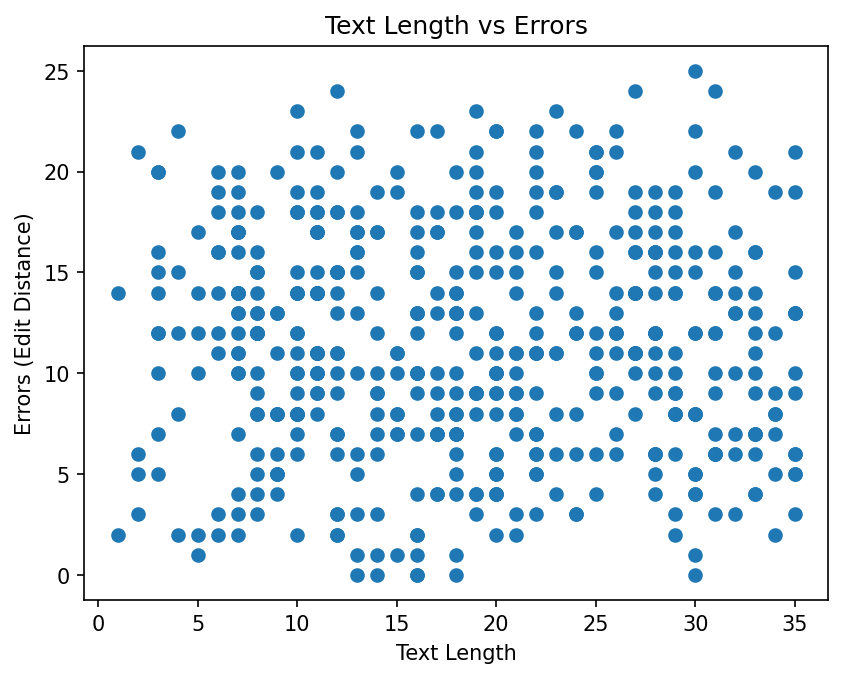

Character influence on errors (sorted by most errors):
Character:  , Total Errors: 18482
Character: e, Total Errors: 10536
Character: t, Total Errors: 6626
Character: o, Total Errors: 6466
Character: a, Total Errors: 6046
Character: n, Total Errors: 5244
Character: i, Total Errors: 5128
Character: s, Total Errors: 5044
Character: r, Total Errors: 5032
Character: h, Total Errors: 4272
Character: ., Total Errors: 3375
Character: l, Total Errors: 3092
Character: d, Total Errors: 3088
Character: u, Total Errors: 2258
Character: f, Total Errors: 2061
Character: c, Total Errors: 1966
Character: y, Total Errors: 1917
Character: p, Total Errors: 1780
Character: w, Total Errors: 1748
Character: m, Total Errors: 1522
Character: g, Total Errors: 1401
Character: b, Total Errors: 1164
Character: v, Total Errors: 959
Character: ", Total Errors: 684
Character: k, Total Errors: 636
Character: I, Total Errors: 555
Character: ,, Total Errors: 551
Character: ', Total Errors: 499
Character: T, Total Error

In [30]:

# Analyze characteristics
analyze_characteristics(results, sentences[:len(results)])

In [31]:
def train_and_evaluate(model, train_loader, test_loader, device, num_epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, targets, lengths in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images).log_softmax(2)
            input_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long)
            loss = criterion(outputs, targets, input_lengths, lengths)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, targets, lengths in test_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images).log_softmax(2)
                input_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long)
                loss = criterion(outputs, targets, input_lengths, lengths)
                val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))

    results = evaluate(model, test_loader, device)
    return results, train_losses, val_losses


Bidirectional LSTM Results: [4, 4, 6, 4, 9, 9, 0, 1, 6, 3, 5, 4, 8, 1, 5, 22, 5, 5, 0, 4, 5, 6, 2, 0, 1, 1, 6, 3, 0, 7, 3, 7, 3, 1, 12, 3, 2, 11, 4, 4, 11, 5, 3, 2, 1, 4, 1, 15, 3, 2, 4, 0, 7, 19, 8, 12, 6, 6, 3, 0, 1, 4, 3, 7, 13, 2, 16, 5, 6, 4, 3, 2, 4, 2, 1, 8, 15, 3, 6, 0, 2, 10, 2, 2, 3, 7, 3, 6, 1, 4, 2, 7, 11, 6, 3, 5, 1, 9, 9, 4, 2, 5, 9, 8, 0, 4, 7, 2, 2, 2, 6, 1, 2, 3, 4, 0, 8, 5, 14, 4, 13, 6, 6, 8, 7, 7, 2, 8, 9, 8, 7, 8, 7, 0, 4, 4, 2, 4, 6, 11, 1, 3, 5, 4, 6, 5, 6, 6, 4, 8, 12, 6, 0, 6, 4, 6, 8, 0, 6, 2, 0, 10, 1, 0, 13, 3, 0, 16, 3, 1, 2, 9, 3, 8, 0, 11, 0, 9, 3, 2, 3, 11, 3, 11, 8, 2, 12, 2, 7, 6, 7, 5, 2, 11, 8, 5, 2, 2, 5, 1, 7, 3, 4, 3, 4, 1, 9, 4, 1, 4, 1, 2, 6, 2, 2, 2, 0, 2, 7, 0, 2, 4, 14, 10, 0, 4, 10, 10, 1, 9, 5, 15, 8, 5, 4, 3, 4, 9, 5, 6, 1, 0, 0, 9, 13, 3, 0, 2, 0, 9, 3, 15, 7, 5, 2, 2, 7, 4, 5, 8, 7, 0, 5, 7, 4, 0, 7, 8, 6, 3, 10, 10, 2, 9, 2, 7, 0, 17, 8, 0, 2, 8, 2, 3, 6, 8, 14, 7, 1, 3, 8, 5, 3, 10, 5, 3, 12, 7, 4, 6, 20, 16, 0, 7, 0, 5, 5, 1, 5, 11, 0

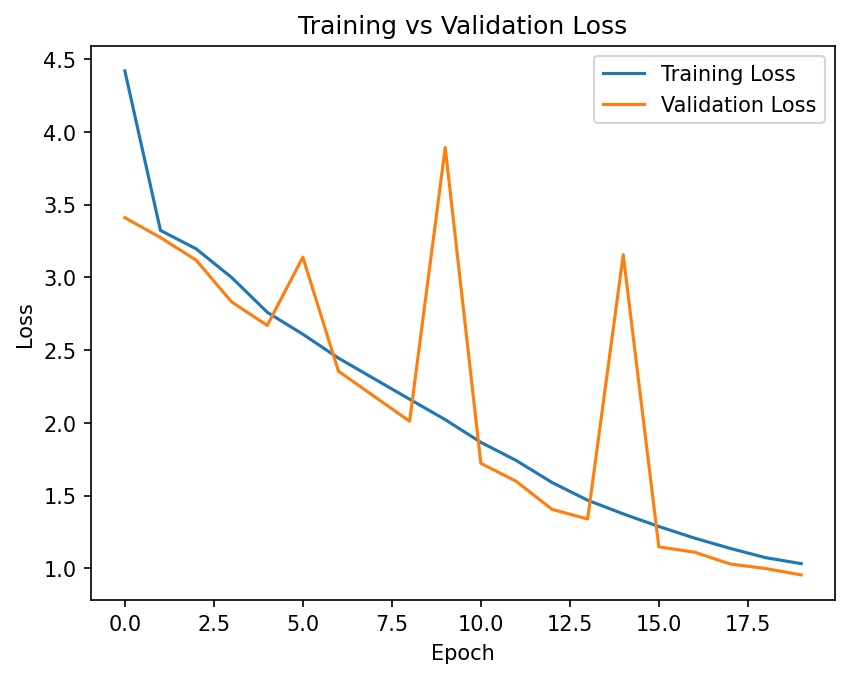

In [32]:


# Bidirectional LSTM
bidirectional_model = TextRecognizer(labels, bidirectional=True, use_dropout=True).to(device)
bidirectional_results, bidirectional_train_losses, bidirectional_val_losses = train_and_evaluate(bidirectional_model, train_loader, test_loader, device)

# Simple LSTM
simple_lstm_model = TextRecognizer(labels, bidirectional=False, use_dropout=True).to(device)
simple_lstm_results, simple_train_losses, simple_val_losses = train_and_evaluate(simple_lstm_model, train_loader, test_loader, device)

# Bidirectional LSTM without dropout
bidirectional_no_dropout_model = TextRecognizer(labels, bidirectional=True, use_dropout=False).to(device)
bidirectional_no_dropout_results, no_dropout_train_losses, no_dropout_val_losses = train_and_evaluate(bidirectional_no_dropout_model, train_loader, test_loader, device)

# Display results
print("Bidirectional LSTM Results:", bidirectional_results)
print("Simple LSTM Results:", simple_lstm_results)
print("Bidirectional LSTM without Dropout Results:", bidirectional_no_dropout_results)

# Function to check for overfitting
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

# Plot losses to check for overfitting
plot_loss(bidirectional_train_losses, bidirectional_val_losses)
